In [1]:
import chickpea
import legume
import numpy as np
import time

%load_ext memory_profiler

# Motivation and Background

~Something about Photonic Crystal Cavities and why they are interesting.~

These tutorials presume basic familiarity with the concepts of photonic band gaps and wave mechanics.
Recommended reading for those unfamiliar is the textbook [Molding the Flow of Light](http://ab-initio.mit.edu/book/),
In particular Chapters 1-5, 7-8.


### Cavity Topology

Photonic Crystal Cavities are classified by their topology. Examples implemented are H_n and L_m-n crystals.
Both of these topologies are built on hexagonal lattices of holes that maintain a TE bandgap.

In H_n crystals, n hexagonal rings of holes removed from the defect region. In L_m/n crystals,
n holes are replaced by m holes in a line.

The precise placement and parameters of these holes is not a matter of topology but of optimization.

### Analysis

For our analysis we choose an H2 Crystal, not just because of its presence in literature Y. Tang 2005,
but also because of the availability of analysis done using alternative
[FDTD techniques](https://support.lumerical.com/hc/en-us/articles/360041567754-Photonic-crystal-cavity).

We start by defining our crystal.

As we define our crystal we have several choices to make.
The supercell we define, including the defect region, will be tiled infinitely,
how many periods of bulk crystal should lie between each defect region?
See Tutorial on [Localization and Supercell Effects](04_Localization_and_Supercell_Effects.ipynb)
for an answer. However we choose the anzats of 18 in both directions.


In [2]:
#Number of PhC periods in x and y directions.

Nx, Ny = 18, 18

a=1 # Bulk Lattice constant.

# Regular PhC parameters chosen from Tang et al.
dslab = 0.26/0.366*a
n_slab = 3.4
ra = 0.37*a

# We use the PCC module of chickpea to initialize an H2 Crystal lattice topology.

pcc = chickpea.PhotonicCrystalCavity(crystal='H', n=2, supercell_size=(Nx, Ny),
                                     thickness=dslab, radius=ra, eps=n_slab**2)

# We generate the photonic crystal object from the photonic crystal cavity object.
phc = pcc.cavity()

We can visualize the phc using the legume visualization tool.

array([[11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56],
       [11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56],
       [11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56],
       ...,
       [11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56],
       [11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56],
       [11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56]])

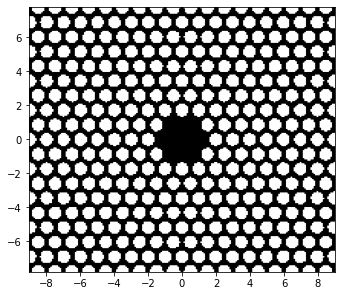

In [3]:
legume.viz.eps_xy(phc, z=dslab/2, Nx=200, Ny=200)

To analyze defect modes in the H2 Crystal it is useful to know some properties of the base crystal
the defect is embedded in.

We can use the pcc object to generate our base crystal for us.

In [4]:
base_phc = pcc.get_base_crystal()

We can aid and automate our analysis using the CavityModeAnalysis object provided by Chickpea.
To do so we first need to define some meta-parameters.

In particular what choice of gmax we need to simulate at to get reasonably accurate results.

We choose a gmax of 2 for both the base crystal and the cavity. We do not expect to get particularly accurate
values for Q at this gmax, however we can analyze frequency
. See the tutorial [Convergence and gmax](03_Convergence_and_gmax.ipynb).



Another parameter is the defect margins parameter.
This defines the margins of the crystal we can ignore for the purpose of mode volume calculations.
For explanation see [Normalization and Mode Volume](05_Normalization_and_Mode_Volume.ipynb) tutorial.

In [5]:
defect_margins = np.array([0.25,0.25])
cma = chickpea.CavityModeAnalysis(phc, base_phc, defect_margins, layer=0, gmax=2, base_gmax=3)

The Cavity Mode Analysis object helps us keep track of all the information about the photonic crystal cavity.
Including the behaviour of the bulk crystal.
We know that the modes are going to be located in the band gap of the bulk crystal we can find the band gaps
and generate a band diagram via the find_band_gaps function.

Band gap lower bound: 0.276746.
Band gap upper bound: 0.420195.
Band gap center: 0.348471.
Gap-midgap ratio: 0.411654.
The top of the air band is at k= (3.141593, 1.813799).
The bottom of the dielectric band is at k= (4.188790, 0.000000).



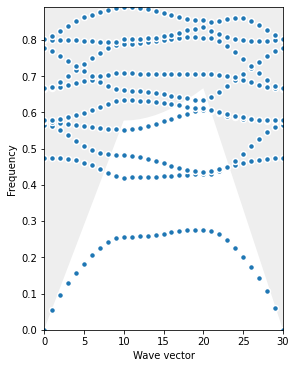

In [6]:
band_gaps, k_air, k_eps =cma.find_band_gaps(band_tol=0.1,
                                            order=np.array([0]), # The order of modes that we care about.
                                                                 # TE modes are numbers [0,2,4,6,8]
                                                                 # We happen to know that higher order modes are
                                                                 # well above the bandgap
                                            trim_lc=True, # We only care about out of light-cone modes.
                                            lc_trim=0.04, # The lc-trim parameter governs how close to the light cone
                                                          # we tolerate.
                                            numeig=10)

gmg_ratio = np.array([(band_gap[1] - band_gap[0]) / band_gap[2] for band_gap in band_gaps])

legume.viz.bands(cma.base_gme,  trim_light_cone=False, lc_trim=0.04)

# There is only one band-gap for this crystal with properties.
print("Band gap lower bound: %f.\n"
      "Band gap upper bound: %f.\n"
      "Band gap center: %f.\n"
      "Gap-midgap ratio: %f.\n"
      "The top of the air band is at k= (%f, %f).\n"
      "The bottom of the dielectric band is at k= (%f, %f).\n" %  (band_gaps[0][0], band_gaps[0][1], band_gaps[0][2],
                                                                   gmg_ratio[0], k_air[0], k_air[1], k_eps[0], k_eps[1]))

We see

In [7]:

options = {'verbose': True,
           'gmode_inds': [0], # This is a TE band gap and we assume that there are no higher order modes.
           'gradients': 'approx', # We don't need exact gradients at this time.
           'numeig': 30, # We happen to know this is a good number to fill the band gap.
                         # Run with higher value until you save modes outside of the band gap.
           'eig_solver': 'eigh',
           'eig_sigma': band_gaps[0][2], # We target the center of the band gap
           'compute_im': False # We only want to calculate the loss rates for cavity modes.
           }

# We simulate on several k-points away from the light cone and one closer to the center.

bz = cma.gme.phc.lattice.get_irreducible_brioullin_zone_vertices()

kpoints = np.array([[k_air[0][0]],[k_air[1][0]]])

%memit cma.gme.run(kpoints=kpoints, **options)

134.4141s total time for real part of frequencies, of which
  0.3819s for guided modes computation using the gmode_compute='exact' method
  2.2576s for inverse matrix of Fourier-space permittivity
  118.5768s for matrix diagionalization using the 'eigh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes
peak memory: 3826.09 MiB, increment: 3715.75 MiB


Because we simulated outside the light cone we can filter cavity modes by
restricting the frequency range to the band gap and filtering off high mode volume modes.

In [8]:
arg_list, v = cma.filter_for_defect_mode(max_volume=5, band_filter=band_gaps)

Let us calculate the loss rates for this modes.

In [9]:

q, freqs_im, rad_coup, rad_gvec = cma.calculate_loss_rates_and_coupling(arg_list)

Now that we know the loss rates le

KeyboardInterrupt: 

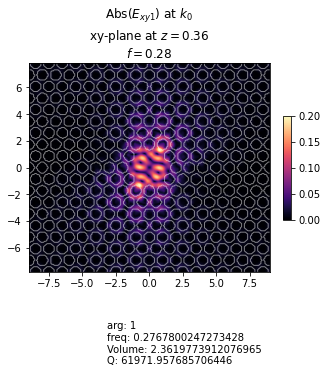

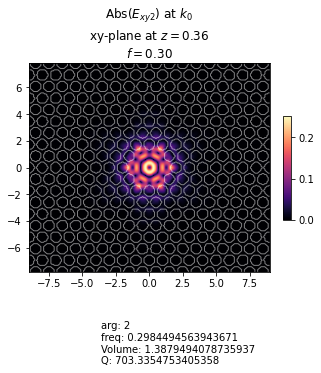

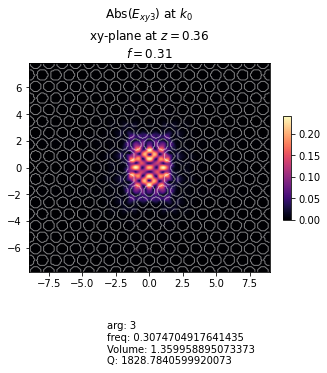

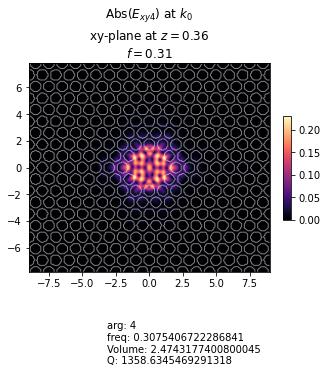

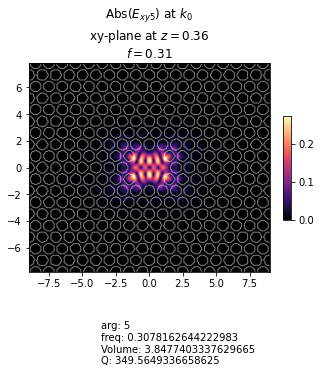

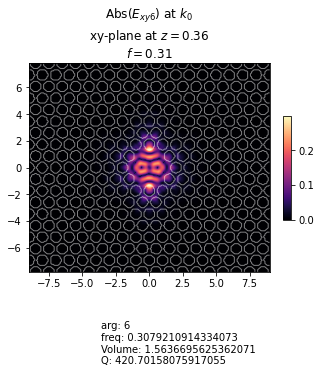

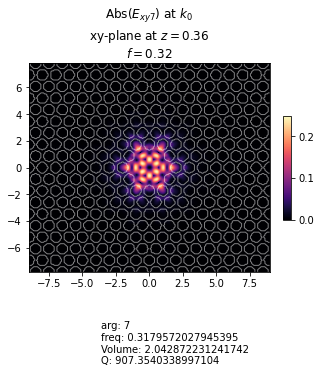

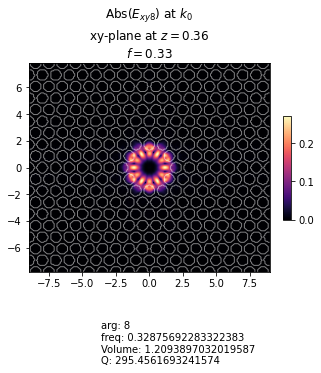

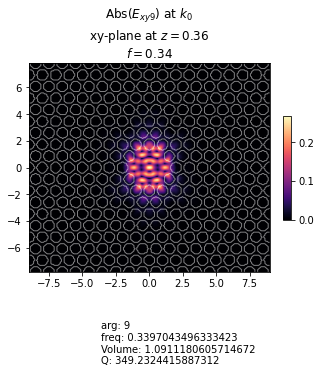

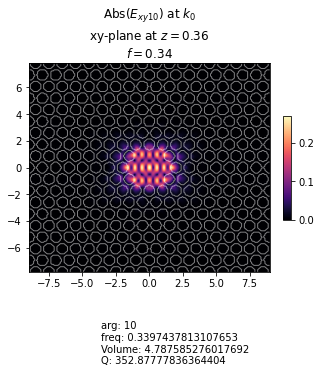

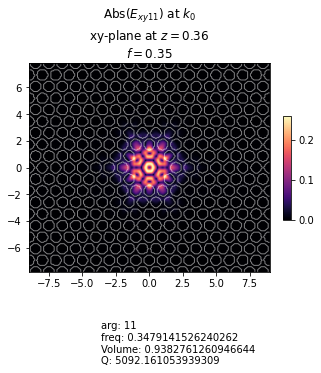

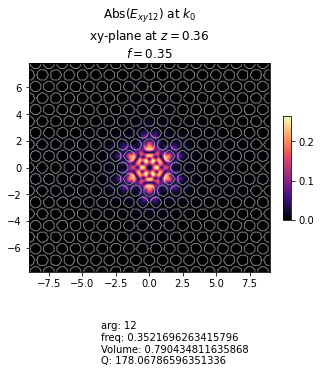

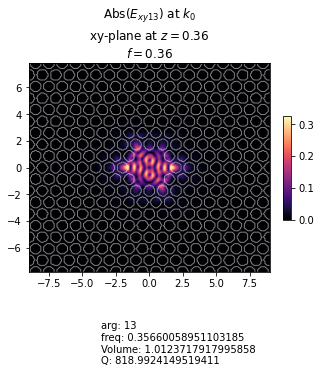

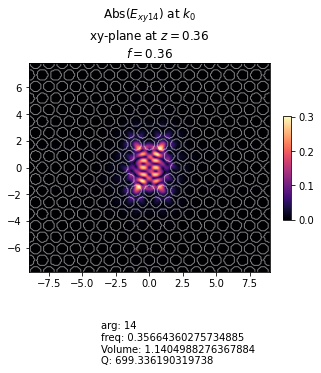

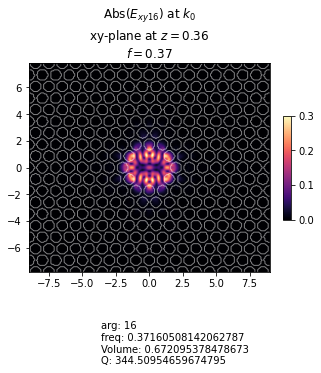

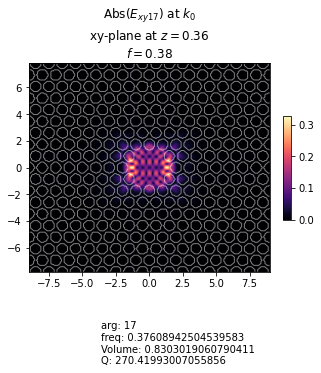

In [10]:
for kind, mlist in enumerate(arg_list):
    for i, mind in enumerate(mlist):
        fig=legume.viz.field(cma.gme,'E', kind, mind, z=dslab/2, component='xy', val='abs', N1=200, N2=200, norm=True)
        fig.text(0.5,-0.25,
                 "arg: " + str(mind)+ "\n"
                 + "freq: " + str(cma.gme.freqs[kind][mind]) + "\n"
                 + "Volume: " + str(v[kind][i]) + "\n"
                 + "Q: " + str(q[kind][i]))

In [ ]:
freqs = cma.gme.freqs[0][arg_list[0]]